In [2]:
Набор данных: ONLINEADS, 13 переменных 20000 строк

Описание: Международная бизнес-площадка запустила тестовую рекламу в интернете на жителей Москвы и Санкт-Петербурга. 
После проведения рекламной кампании были собраны данные о пользователях перешедших на сайт.

Цель: ислледование наилучшей модели для предсказания какие пользователи в будущем 
будут регистрироваться на площадке

Описание признаков: 
1) ID                                           5) VisitTime : Каждое число из набора данных соответствует определенному часу.
2) Age:                                         6) City: Москва = 0, Санкт-Петербург  = 1
    18‑24 года = 0  
    25‑34 года = 1 
    35‑44 года = 2 
    45-54 года = 3 
    55 лет и старше = 4
3) Gender: Неизв = 0, М = 1, Ж = 2              7) Device: ПК = 0, Смартфон = 1
4) Interest:                                    8) OC : Mac OS = 0, Windows = 1, Android = 2, IOS = 3
    Бизнес = 0           Автомобили = 5
    Литература = 1       Кулинария = 6 
    Кино = 2             Недвижимость = 7 
    Семья и дети = 3     Обустройство = 8
    Туризм = 4           Мобильная связь и интернет = 9
9) VisitPage : Главная страница = 0, Специально разработанная для рекламной кампании страница = 1
10) AdsTool(Источник перехода): Таргетированная реклама = 0, Контекстная реклама = 1, Прямые переходы = 2, SEO = 3, Социальные сети = 4, Остальные = 5
11) VisitNumber(Является ли переход на сайт первым визитом посетителя? )
    Новые посетители = 0, Вернувшиеся посетители = 1
12) ViewedPage(Количество просмотренных страниц перед регистрацией):
    32-63 страниц = 0  2-3 страниц = 4 
    16-31 страниц = 1  1 страниц = 5 
    8-15 страниц = 2   Остальные = 6
    4-7 страниц = 3 
13) Registration(Пользователь зарегистрировался?) Да = 1, Нет = 0

`

SyntaxError: invalid syntax (<ipython-input-2-38558866e510>, line 1)

In [7]:
#В данном блоке происходит загрузка и подготовка данных, выбора необходимых признако
#а также вспомогательные методы построения и вывода графиков, которые потребуются в следующих блоках
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import pydot

from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

plt.style.use('ggplot')

#подготавливаем данные 
def process_data_frame():
    #в переменную помещаем таблицу ONLINEADS
    process_df = pd.read_excel('resources/xlsx/ONLINEADS.xlsx',
                               sheet_name=0,
                               index_col=0
                               )
    #производим замену отсутствующих значений, берем моду по числовому значению,
    #и в пусты строки добавляем средние значения
    process_df = process_df.fillna(process_df.mode().iloc[0])

    return process_df

# выдает те признаки по которым стоит модель,
# отбирая признаки по значениям матрицы корреляции
def get_x_y_after_correlation(df, target):
    cor = make_correlation_matrix(df)
    
    # Берем значение корреляции по модулю
    cor_target = abs(cor[target])

    # Выбираем признаки с высоким значением корреляции >=0,2
    relevant_features = cor_target[cor_target >= 0.2].drop(target)
    
    #вывод этих значений
    print(relevant_features, "\n-----------------")
    relevant_features = relevant_features.index.tolist()
    print(df[relevant_features].corr(), "\n------------------")
    
    # Возьмем X и Y
    x = df[relevant_features]
    y = df[target]
    y = y.astype('int')

    return x, y, relevant_features

# выдает x и y, где х выбирается с помощью метода одномерного отбора,
# использующего хи-квадрат, чтобы вычислить лучшие признаки
def get_x_y_after_unv_sel(df, target):
    
# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
    x = df
    x = x.drop(columns=[target])
    y = df[target]

    # обучаем, выбираем,используя chi квадрат
    best_features = SelectKBest(score_func=chi2, k=10)

    fit = best_features.fit(x, y)
    # берем результаты
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    # объединяем 2 фрейма и выводим их в консоль
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']
    featureScores = featureScores.nlargest(len(df.columns), 'Score')
    
    # выводим график со значением важности по каждому признаку
    y_axis = []
    y_stickers = []

    for j in featureScores.values:
        y_axis.append(j[1])
        y_stickers.append(j[0])

    ind = np.arange(len(y_axis))
    plt.barh(ind, y_axis, align='center')
    plt.yticks(ind, y_stickers)
    
    plt.show()
    plt.close()

    # удаляем признаки, которые имеют наименьшее значение
    x = x.drop(columns=['OS', 'VisitNumber', 'VisitPage', 'City', 'Gender'])

    return x, y

# выбор X, используя метод важности критериев
def get_x_y_after_imp_selection(df, target):
    
# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
    x = df
    x = x.drop(columns=[target])
    y = df[target]

    model = ExtraTreesClassifier()
    model.fit(x, y)
    # используйте встроенный класс feature_importances древовидных классификаторов
    # построить график важности объектов для лучшей визуализации
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()
    plt.close()

    x = df[['Interest', 'OS', 'Age', 'Device', 'VisitTime']]

    return x, y

# построение и вывод графика ROC кривой
def plot_roc_curve(fpr, tpr, n, current_score):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with AUC score - %.4f' % current_score)
    plt.legend()
    plt.show()
    plt.close()

#построение и вывод графика оценки (лестничная структура)
def plot_score_graphic(x_array, y_array, filename):
    fig = plt.figure(figsize=(25, 11), dpi=100)
    plt.plot(x_array, y_array, 'bo-')

    for i, j in zip(x_array, y_array):
        label = "{0:.3f}".format(j)

        plt.annotate(label,
                     xy=(i, j),
                     xytext=(0, 10),
                     textcoords="offset points",
                     ha='center'
                     )

    plt.show()
    plt.close(fig)

# построение и вывод матрицы корреляции
def make_correlation_matrix(matrix_df):
    fig = plt.figure(figsize=(14, 11), dpi=100)

    correlation_matrix = matrix_df.corr()

    sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
    plt.show()
    plt.close(fig)

    return correlation_matrix

# создание png файлов для отрисовки решаюших деревьев
def create_png_image_for_extended_tree(treeEnt, fileDot, filePng, names):
    export_graphviz(treeEnt, out_file=fileDot,
                    rounded=True, proportion=False,
                    precision=3, filled=True,
                    class_names=True,
                    feature_names=names
                    )

    (graph,) = pydot.graph_from_dot_file(fileDot)

    graph.write_png(filePng)

    return 1

# Вывод таблицы результатов по модели
def plot_score_table(x):
    columns = ['Model', 'Accuracy', 'AUC', 'RMSE', 'R2']

    fig, ax = plt.subplots(dpi=300)

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    df = pd.DataFrame(x, columns=columns)

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    fig.tight_layout()

    plt.show()
    plt.close()

----------------------------------
Filtration with Correlation Matrix
----------------------------------


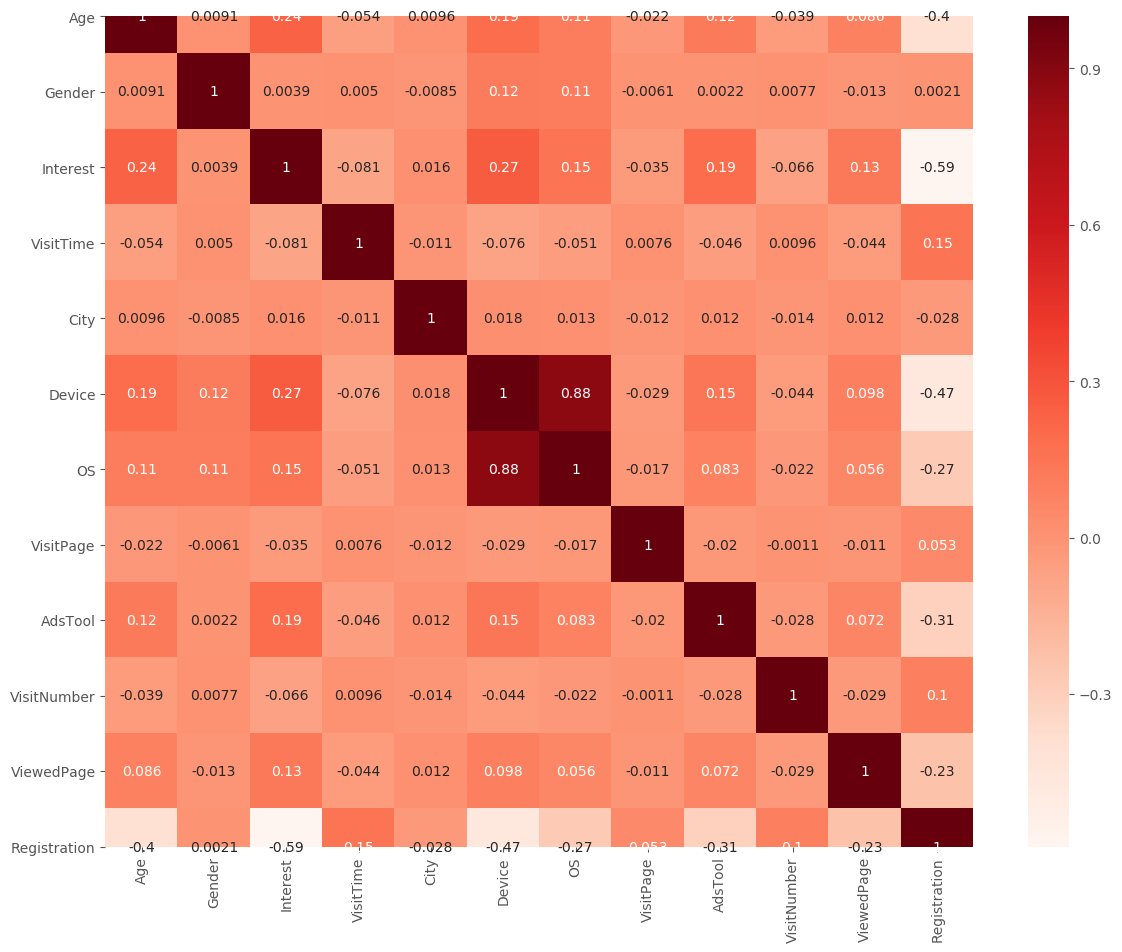

Age           0.398559
Interest      0.592589
Device        0.469079
OS            0.270149
AdsTool       0.307272
ViewedPage    0.226248
Name: Registration, dtype: float64 
-----------------
                 Age  Interest    Device        OS   AdsTool  ViewedPage
Age         1.000000  0.235423  0.188842  0.106212  0.122995    0.085604
Interest    0.235423  1.000000  0.268487  0.151059  0.186778    0.130112
Device      0.188842  0.268487  1.000000  0.879765  0.146692    0.097824
OS          0.106212  0.151059  0.879765  1.000000  0.082800    0.056454
AdsTool     0.122995  0.186778  0.146692  0.082800  1.000000    0.071502
ViewedPage  0.085604  0.130112  0.097824  0.056454  0.071502    1.000000 
------------------


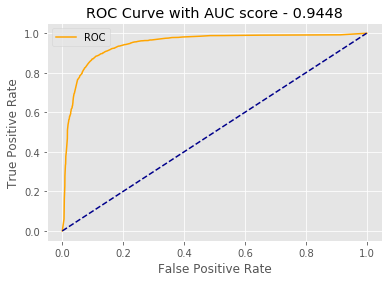

Tree with Gini
Accuracy score 0.88467
Cross val score 0.88667
Auc score 0.94480
Mean squared error - 0.29354
R2 score - 0.65533
-----------------------


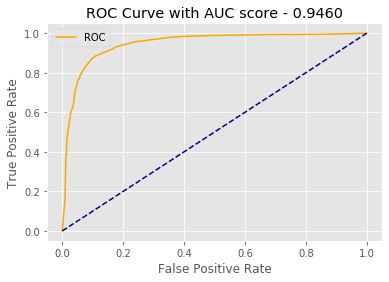

Tree with Entropy
Accuracy score 0.88600
Cross val score 0.88250
Auc score 0.94597
Mean squared error - 0.29302
R2 score - 0.65656
-----------------------
----------------------------------
Filtration with Unvariate Selection
----------------------------------


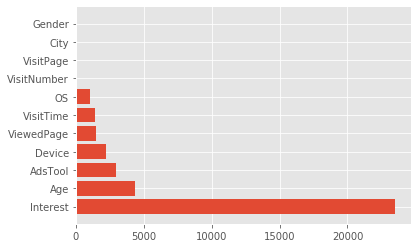

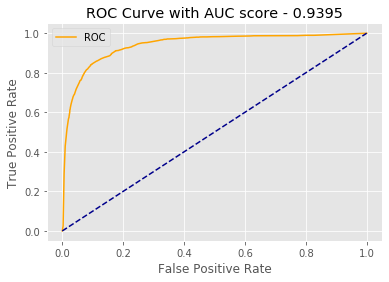

Tree with Gini
Accuracy score 0.87167
Cross val score 0.86428
Auc score 0.93954
Mean squared error - 0.30559
R2 score - 0.62643
-----------------------


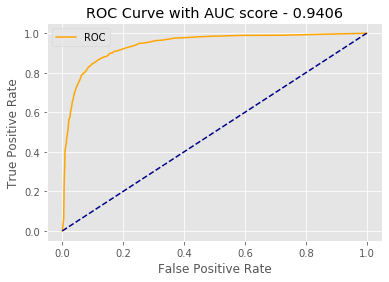

Tree with Entropy
Accuracy score 0.87333
Cross val score 0.87261
Auc score 0.94060
Mean squared error - 0.30443
R2 score - 0.62928
-----------------------
----------------------------------
Filtration with Importance Selection
----------------------------------


C:\Users\bloof\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


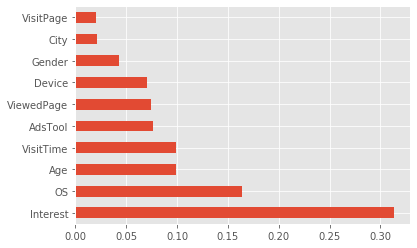

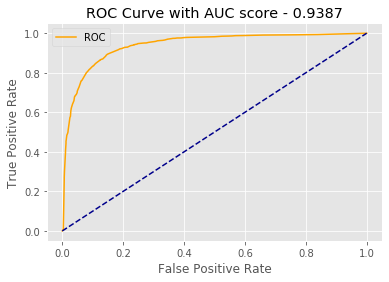

Tree with Gini
Accuracy score 0.87100
Cross val score 0.87427
Auc score 0.93874
Mean squared error - 0.30681
R2 score - 0.62336
-----------------------


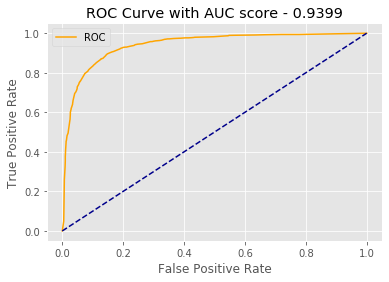

Tree with Entropy
Accuracy score 0.87233
Cross val score 0.87677
Auc score 0.93987
Mean squared error - 0.30557
R2 score - 0.62641
-----------------------


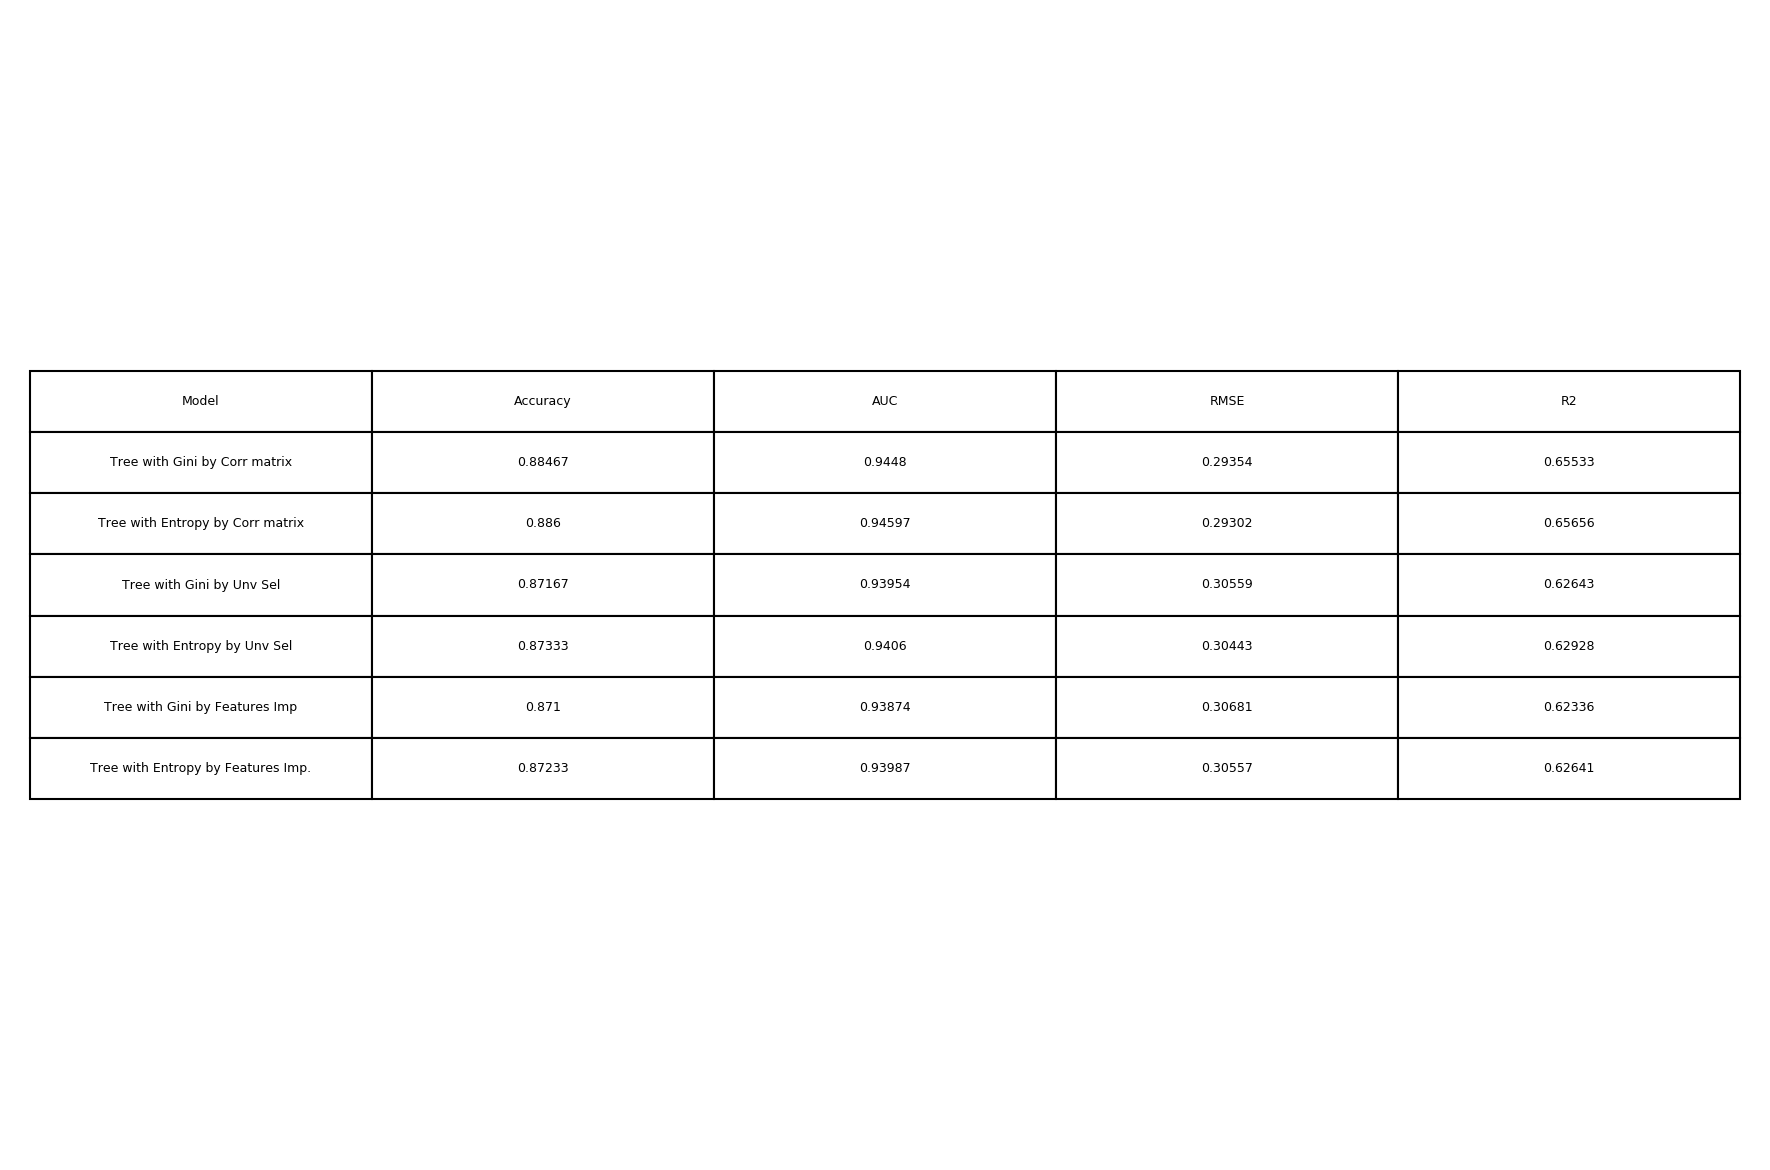

In [8]:
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

# производим подготовку данных
df = process_data_frame()
# Инициализируем массив для сбора результатов по каждой модели
x_table = []
#
# выбираем целевой признак, который собираемся предсказывать - это регистрация
target = 'Registration'
# ----------------------
# Выбираем признаки с помощью матрицы корреляции
#
print('----------------------------------')
print('Filtration with Correlation Matrix')
print('----------------------------------')
# используем метод, описанный в предыдущем блоке, который возвращает признаки, по которым строится модель
x, y, relevant_features = get_x_y_after_correlation(df, target)

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# строим дерево решений по критерию Джини, с максимальной глубиной 8 и минимальным количеством листьев 2
# (Filtration with Correlation Matrix)
#random_state генератор псевдо случайных чисел, которые используются при построении модели 
# и влияют на ее изначальные веса\коэффициенты, по которым потом вычисляется предсказания. 
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='gini',
                               min_samples_leaf=2,
                               )
# обучаем модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#вычислений предсказаний по каждому из объектов в x, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится тот или иной объект
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)

#используем метод, описанный в предыдущем блоке, который строит и выводит график ROC-кривой
plot_roc_curve(fpr, tpr, "tree/roc/cor_gini", auc)

fileDot = 'resources/tree/model/cor_gini.dot'
filePng = 'resources/tree/model/cor_gini.png'

# вывод результатов
#create_png_image_for_extended_tree(model, fileDot, filePng, relevant_features)

print('Tree with Gini')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Gini by Corr matrix', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#
# строим дерево решений с максимальной глубиной 8, количество листов 2 по критерию энтропии (Filtration with Correlation Matrix)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='entropy',
                               min_samples_leaf=2,
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "tree/roc/cor_entropy", auc)

fileDot = 'resources/tree/model/cor_ent.dot'
filePng = 'resources/tree/model/cor_ent.png'

# вывод результатов
#create_png_image_for_extended_tree(model, fileDot, filePng, relevant_features)

print('Tree with Entropy')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Entropy by Corr matrix', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#
#
# Выбираем признаки с помощью метода Одномерного отбора
#
print('----------------------------------')
print('Filtration with Unvariate Selection')
print('----------------------------------')

#метод описанный ранее, 
x, y = get_x_y_after_unv_sel(df, target)

# генерируем выборки для тренировки и тестов
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# строим дерево решений по критерию Джини с максимальной глубиной 8, c количеством листьев 2 (Filtration with Unvariate Selection)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='gini',
                               min_samples_leaf=2,
                               )

#построение модели
model.fit(x_train, y_train)

#оценка точности
current_score = model.score(x_test, y_test)

#оценка при кросс валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x нет значений еще, данный метод
#возвращает ID и значение к какому классу, по его мнению относится то или иное значение
probs = model.predict_proba(x_test)
#в probs записываем только значение 
probs = probs[:, 1]

#площадь под ROC кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

#подсчет среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

#коэффициент детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "tree/roc/univariate _gini", auc)

fileDot = 'resources/tree/model/unv_gini.dot'
filePng = 'resources/tree/model/unv_gini.png'

print('Tree with Gini')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Gini by Unv Sel', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

# строим дерево с максимальной глубиной 8 решений по критерию Энтропии (Filtration with Unvariate Selection)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='entropy',
                               min_samples_leaf=2,
                               )
#построение модели
model.fit(x_train, y_train)
#оценка точности
current_score = model.score(x_test, y_test)
#оценка при кросс валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))


#генерируются предсказания, т.к у x нет значений еще, данный метод
#возвращает ID и значение к какому классу, по его мнению относится то или иное значение
probs = model.predict_proba(x_test)
#в probs записываем только значение 
probs = probs[:, 1]

#площадь под ROC кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

#подсчет среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))
#коэффициент детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "tree/roc/univariate_entropy", auc)

fileDot = 'resources/tree/model/unv_ent.dot'
filePng = 'resources/tree/model/unv_ent.png'

print('Tree with Entropy')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Entropy by Unv Sel', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#
# Выбираем признаки по отбору важности признаков
print('----------------------------------')
print('Filtration with Importance Selection')
print('----------------------------------')

# используем метод, описанный в предыдущем блоке - построение и вывод график важности объектов для лучшей визуализации
x, y = get_x_y_after_imp_selection(df, target)

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


# строим дерево решений по критерию Джини см.коментарии на предыдущих (Filtration with Importance Selection)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='gini',
                               min_samples_leaf=2,
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)

#используем метод, описанный в предыдущем блоке, который строит и выводит график ROC-кривой
plot_roc_curve(fpr, tpr, "tree/roc/importance_gini", auc)

fileDot = 'resources/tree/model/imp_gini.dot'
filePng = 'resources/tree/model/imp_gini.png'

# выводим результаты
#create_png_image_for_extended_tree(model, fileDot, filePng, x.columns.tolist())

print('Tree with Gini')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Gini by Features Imp', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

# строим дерево решений по критерию Энтропии (Filtration with Importance Selection)
# random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
# по которым потом вычисляется предсказание
model = DecisionTreeClassifier(max_depth=8,
                               random_state=4,
                               criterion='entropy',
                               min_samples_leaf=2,
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "tree/roc/importance_entropy", auc)

fileDot = 'resources/tree/model/imp_ent.dot'
filePng = 'resources/tree/model/imp_ent.png'

# выводим результаты 
#create_png_image_for_extended_tree(model, fileDot, filePng, x.columns.tolist())

print('Tree with Entropy')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Доблавяем результат в массив
x_table.append(['Tree with Entropy by Features Imp.', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
# Выводим все результаты в таблице
plot_score_table(x_table)

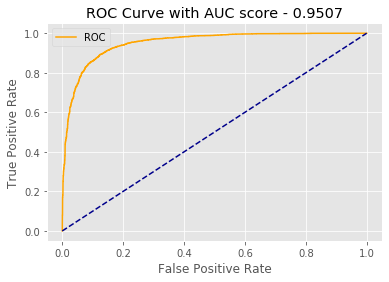

Logistic Regression with Lasso
Score 0.88283
Auc score 0.95072
Mean squared error - 0.29304
R2 score - 0.65650
-----------------------


C:\Users\bloof\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


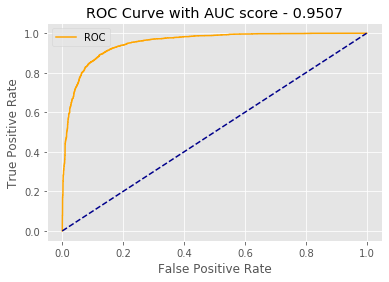

Logistic Regression with Ridge
Score 0.88350
Auc score 0.95073
Mean squared error - 0.29310
R2 score - 0.65636
-----------------------


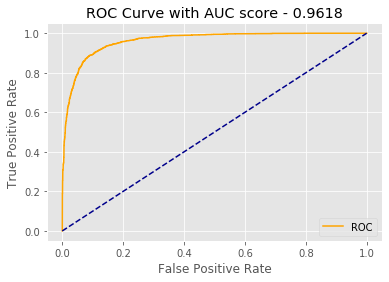

Polynomial Logistic Regression
Score 0.89717
Auc score 0.96181
Mean squared error - 0.27395
R2 score - 0.69981
-----------------------


C:\Users\bloof\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


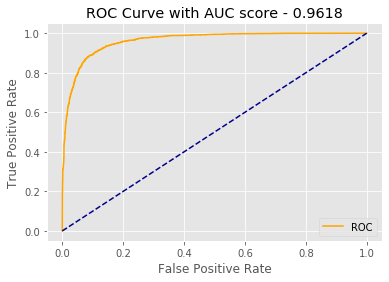

Polynomial Logistic Regression with Ridge
Score 0.89783
Auc score 0.96176
Mean squared error - 0.27400
R2 score - 0.69970
-----------------------


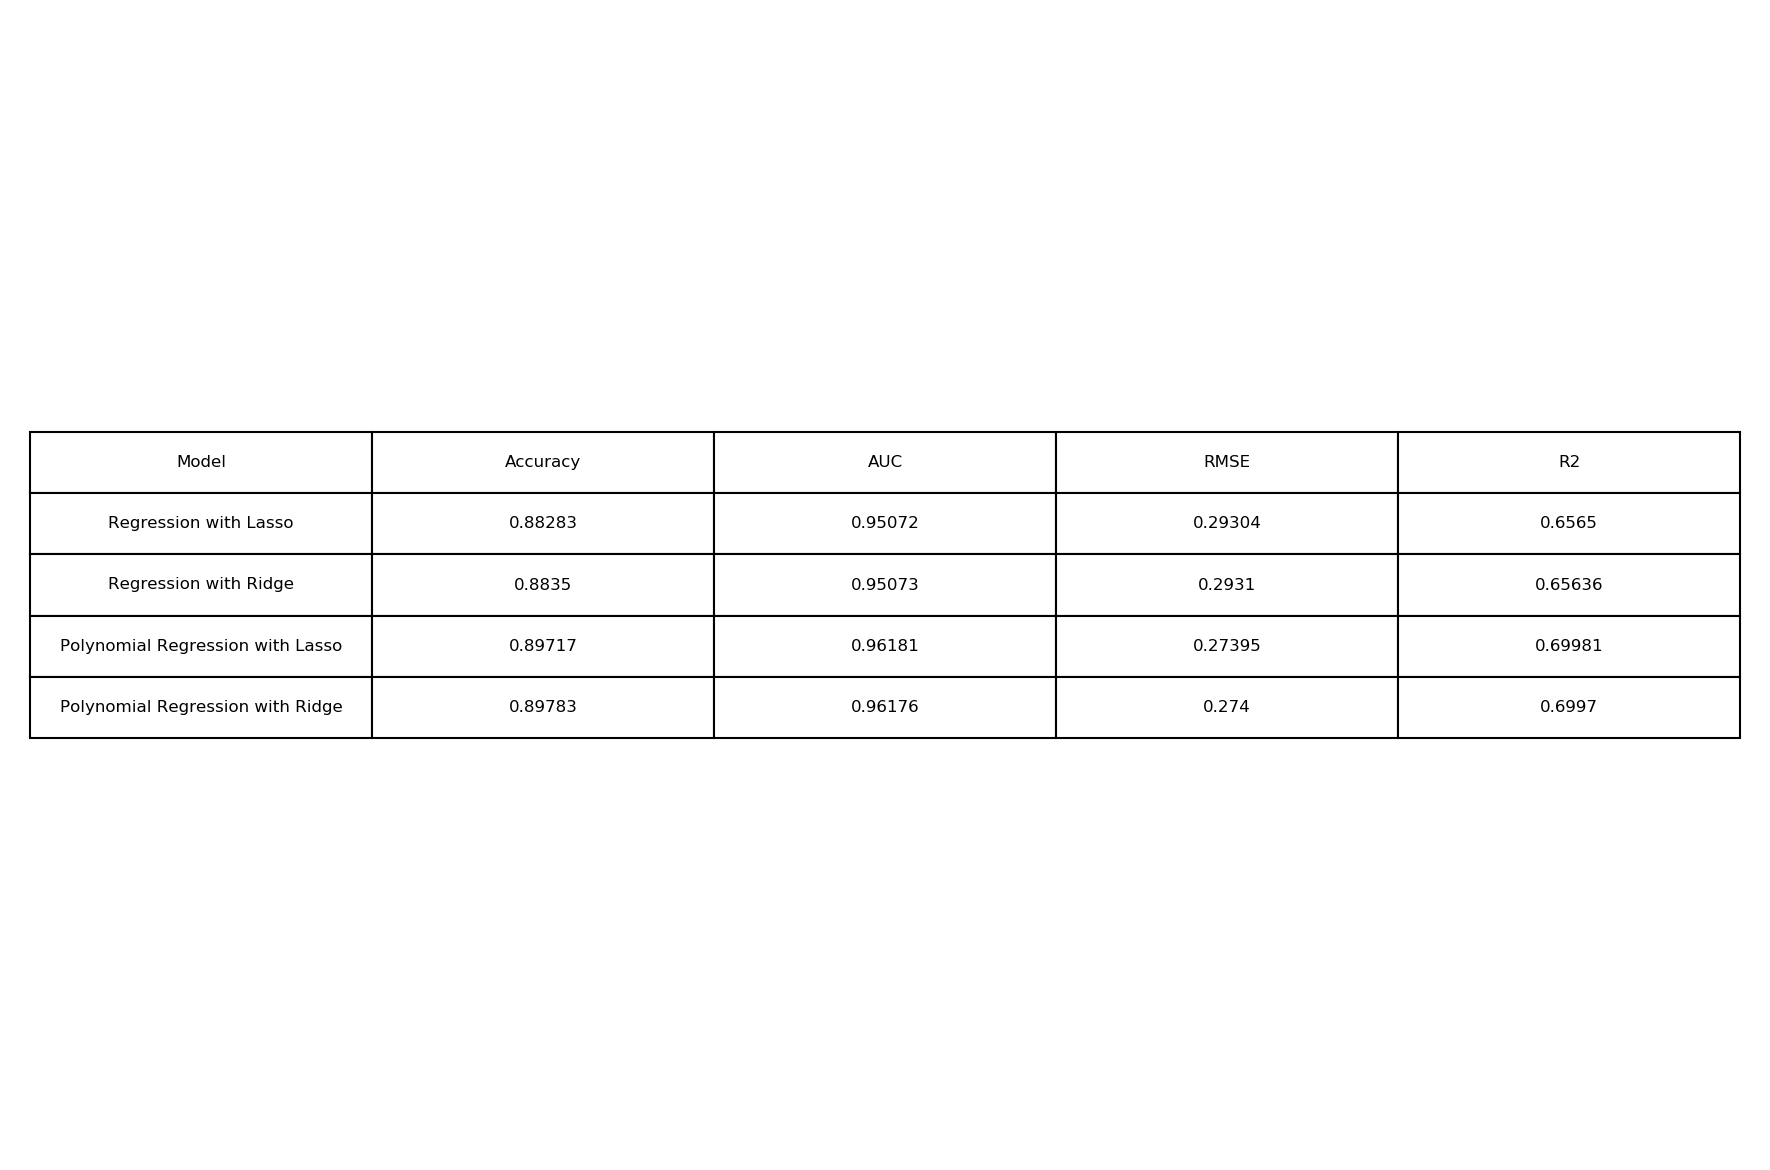

In [9]:
# рассмотрение двух моделей классификации логистической и полиномиальной регрессии
# реализация которых основана на различных вариациях алготирма логистической регрессии
# логистическая регрессия позволяет предсказывать значения непрерывной зависимой переменной на интервале от 0 до 1

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

# производим подготовку данных
df = process_data_frame()
# Инициализируем массив для сбора результатов
x_table = []
#

# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
x = df
x = x.drop(columns=['Registration'])

y = df['Registration']
y = y.astype('int')

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Логистическая регрессия по методу Лассо (Лассо-регрессия)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
# максимально количество иттераций 300
#сбалансировано использует значения y для автоматической настройки весов обратно пропорционально частотам класса входных данных,
# penalty - система наказания по принципу Лассо, т.к l1
#solver - устанавливаем метод оптимизации, т.к маленькая выборка
#multi_class - указывает количетсво признаков, в нашем случае это бинарная классификация 
model = LogisticRegression(
    random_state=4,
    max_iter=300,
    class_weight='balanced',
    penalty='l1',
    solver='liblinear',
    multi_class='ovr'
)

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "logistic_regression/reg_lasso", auc)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# вывод результатов

print('Logistic Regression with Lasso')
print('Score %.5f' % round(current_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Regression with Lasso', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

# Логистическая регрессия по методу Риджа (Ридж-регрессия)
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
# максимально количество иттераций 300
#сбалансировано использует значения y для автоматической настройки весов обратно пропорционально частотам класса входных данных,
# penalty - система наказания по принципу наименьших квадратов, т.к l2
#multi_class - указывает то, что бинарная классификация 
model = LogisticRegression(
    random_state=4,
    max_iter=300,
    class_weight='balanced',
    penalty='l2',
    multi_class='ovr'
)

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "logistic_regression/reg_ridge", auc)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# вывод результатов
print('Logistic Regression with Ridge')
print('Score %.5f' % round(current_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Regression with Ridge', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#


# Polynomial Regression with Lasso
#Сгенерируем новую матрицу признаков, 
#состоящую из всех полиномиальных комбинаций объектов со степенью меньше или равной 2 
poly = PolynomialFeatures(degree=2)

#генерирует матрицу со всеми комбинациями полинома для полин.регрессии и возвращает преобразованную версию X
x_poly = poly.fit_transform(x_train)

#задаем свойства для регрессии
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
# максимально количество иттераций 300
#сбалансировано использует значения y для автоматической настройки весов обратно пропорционально частотам класса входных данных,
# penalty - система наказания по принципу Лассо, т.к l1
#solver - устанавливаем метод оптимизации, т.к маленькая выборка
#multi_class - указывает то, что бинарная классификация, auto==owr
model = LogisticRegression(random_state=4,
                           max_iter=300,
                           class_weight='balanced',
                           penalty='l1',
                           solver='liblinear',
                           multi_class='auto'
                           )

# строим модель
model.fit(x_poly, y_train)

# оцениваем точность
current_score = model.score(poly.transform(x_test), y_test)

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(poly.transform(x_test))
# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)


# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "logistic_regression/poly_lasso", auc)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

print('Polynomial Logistic Regression')
print('Score %.5f' % round(current_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Polynomial Regression with Lasso', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

#
# Polynomial Regression with Ridge
#
poly = PolynomialFeatures(degree=2)

#генерирует матрицу со всеми комбинациями полинома для полин.регрессии и возвращает преобразованную версию X
x_poly = poly.fit_transform(x_train)

#задаем свойства для регрессии
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
# максимально количество иттераций 300
#сбалансировано распределяется вес классов, penalty - система наказания по принципу наиеньших квадратов, т.к l2
#solver - устанавливаем метод оптимизации, т.к маленькая выборка
#multi_class - указаыает то, что бинарная классификация 
model = LogisticRegression(random_state=4,
                           max_iter=300,
                           class_weight='balanced',
                           penalty='l2',
                           multi_class='auto'
                           )
#строим модель
model.fit(x_poly, y_train)

# оцениваем точность
current_score = model.score(poly.transform(x_test), y_test)

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(poly.transform(x_test))
# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
#Чем больше значение AUC, тем «лучше» модель классификации. 
#Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.
auc = roc_auc_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "logistic_regression/poly_ridge", auc)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

print('Polynomial Logistic Regression with Ridge')
print('Score %.5f' % round(current_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Polynomial Regression with Ridge', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
# Выводим таблицу результатов
plot_score_table(x_table)

----------------------------------
Basic Random Forest
----------------------------------


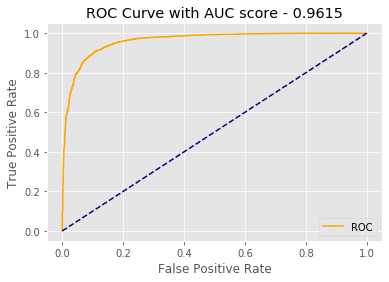

RandomForest score
Accuracy score 0.89917
Cross val score 0.90583
Auc score 0.96154
Mean squared error - 0.27401
R2 score - 0.69959
-----------------------
----------------------------------
Random Forest, filtration with Correlation Matrix
----------------------------------


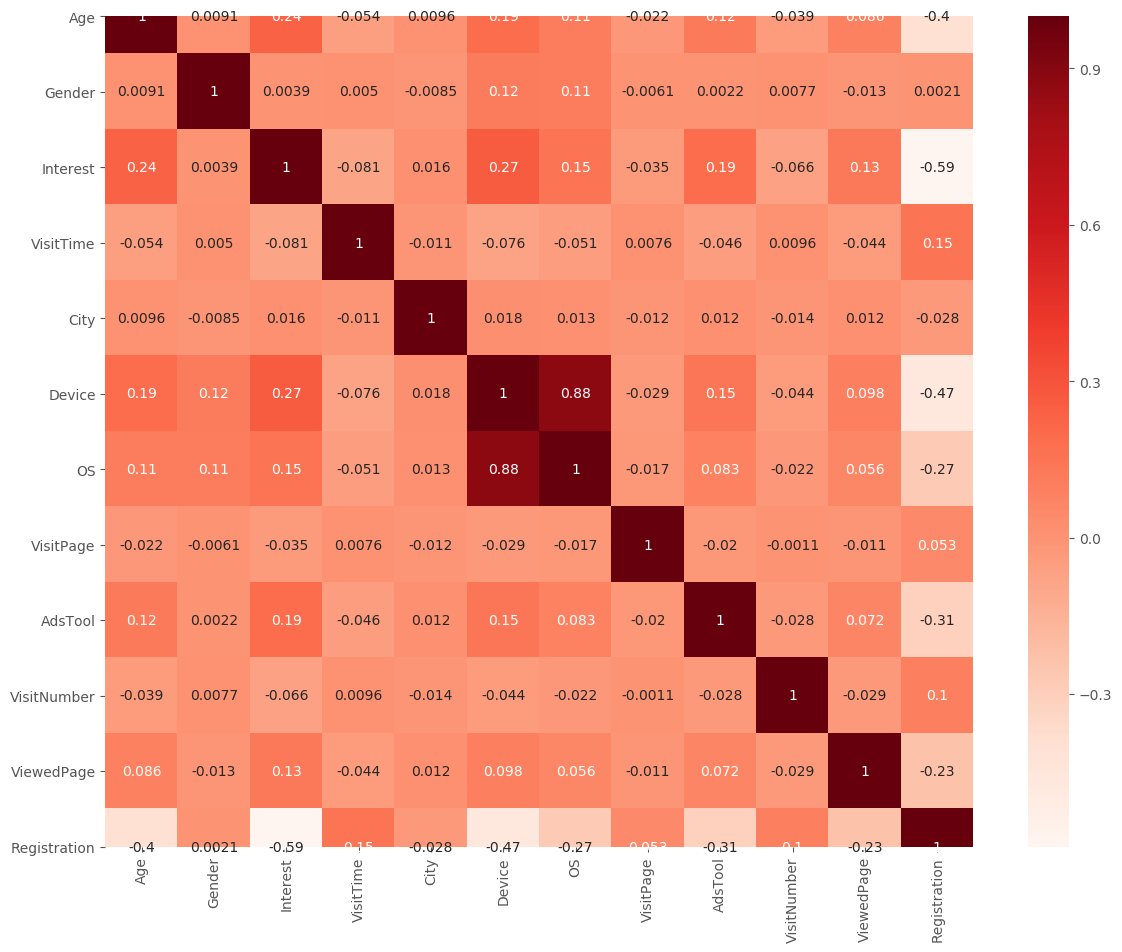

Age           0.398559
Interest      0.592589
Device        0.469079
OS            0.270149
AdsTool       0.307272
ViewedPage    0.226248
Name: Registration, dtype: float64 
-----------------
                 Age  Interest    Device        OS   AdsTool  ViewedPage
Age         1.000000  0.235423  0.188842  0.106212  0.122995    0.085604
Interest    0.235423  1.000000  0.268487  0.151059  0.186778    0.130112
Device      0.188842  0.268487  1.000000  0.879765  0.146692    0.097824
OS          0.106212  0.151059  0.879765  1.000000  0.082800    0.056454
AdsTool     0.122995  0.186778  0.146692  0.082800  1.000000    0.071502
ViewedPage  0.085604  0.130112  0.097824  0.056454  0.071502    1.000000 
------------------


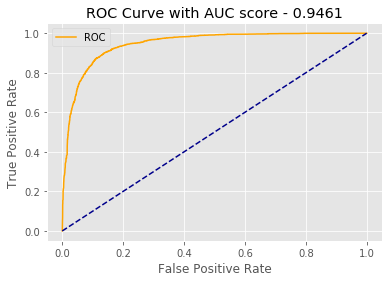

RandomForest score
Accuracy score 0.87933
Cross val score 0.88407
Auc score 0.94613
Mean squared error - 0.29951
R2 score - 0.64117
-----------------------
----------------------------------
Random Forest, importance features filtration
----------------------------------


C:\Users\bloof\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


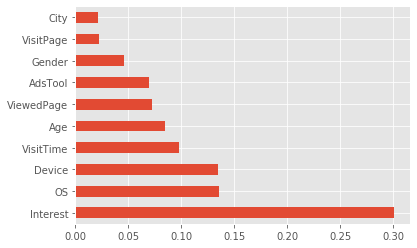

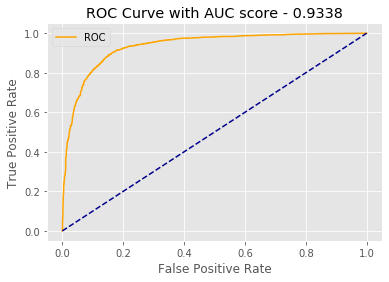

RandomForest score
Accuracy score 0.86667
Cross val score 0.86500
Auc score 0.93383
Mean squared error - 0.31543
R2 score - 0.60201
-----------------------
----------------------------------
Random Forest, unvariate selection filtration
----------------------------------


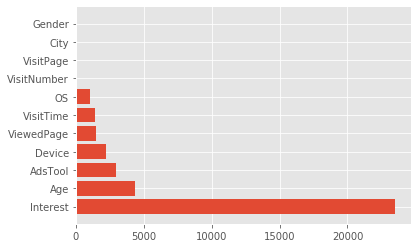

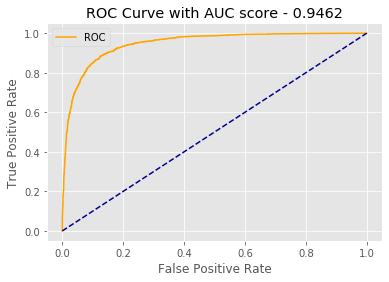

RandomForest score
Accuracy score 0.87617
Cross val score 0.89992
Auc score 0.94624
Mean squared error - 0.29976
R2 score - 0.64048
-----------------------


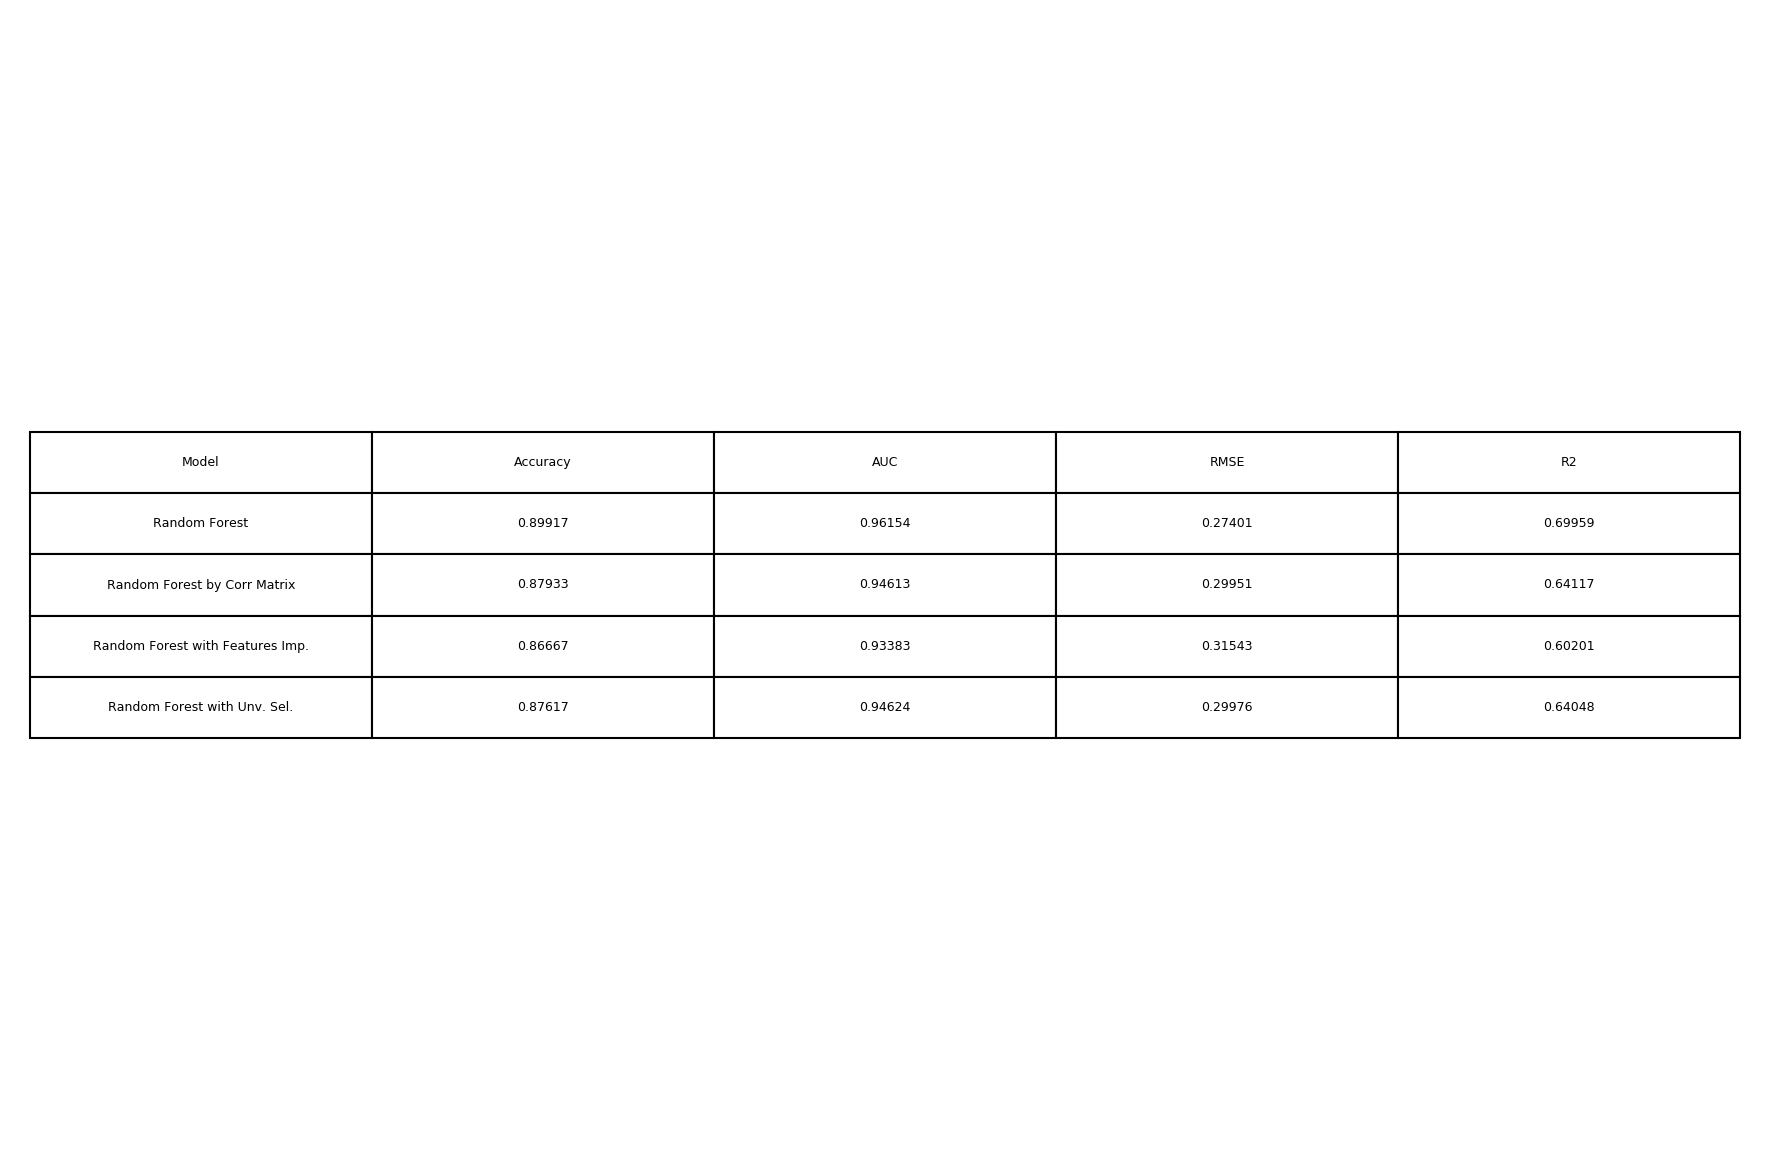

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

df = process_data_frame()
# Иницализируем массив для сбора результатов
x_table = []
#

target = 'Registration'

# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
x = df
x = x.drop(columns=[target])
y = df[target]
y = y.astype('int')

# fit without any filtration
#построение без фильтрации и отсеивания признаков 

print('----------------------------------')
print('Basic Random Forest')
print('----------------------------------')

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для рандомного леса по критерию энтропии
#n_estimators - число деревьев
#макисмальная глубина 12
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#максимальная глубина 12
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
model = RandomForestClassifier(n_estimators=600,
                               max_depth=12,
                               random_state=4,
                               min_samples_leaf=1,
                               oob_score=True,
                               n_jobs=-1,
                               criterion='entropy',
                               max_features='sqrt'
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)
# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)
# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)
# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))
# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "random_forest/roc/forest", auc)

print('RandomForest score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Random Forest', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

# fit after correlation matrix

print('----------------------------------')
print('Random Forest, filtration with Correlation Matrix')
print('----------------------------------')

# используем метод, описанный в предыдущем блоке, который возвращает признаки, по которым строится модель
x, y, relevant_features = get_x_y_after_correlation(df, target)

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для рандомного леса по критерию энтропии
#n_estimators - число деревьев
#макисмальная глубина 12
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#макисмальная глубина 12
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
model = RandomForestClassifier(n_estimators=600,
                               max_depth=12,
                               random_state=4,
                               min_samples_leaf=1,
                               oob_score=True,
                               n_jobs=-1,
                               criterion='entropy',
                               max_features='sqrt'
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "random_forest/roc/forest_cor", auc)

print('RandomForest score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Random Forest by Corr Matrix', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#

#
# fit after correlation matrix
#
print('----------------------------------')
print('Random Forest, importance features filtration')
print('----------------------------------')

# используем метод, описанный в предыдущем блоке, который возвращает признаки, по которым строится модель
x, y = get_x_y_after_imp_selection(df, target)

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для рандомного леса по критерию энтропии
#n_estimators - число деревьев
#макисмальная глубина 12
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#макисмальная глубина 12
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
model = RandomForestClassifier(n_estimators=600,
                               max_depth=12,
                               random_state=4,
                               min_samples_leaf=1,
                               oob_score=True,
                               n_jobs=-1,
                               criterion='entropy',
                               max_features='sqrt'
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "random_forest/roc/forest_imp", auc)

print('RandomForest score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Random Forest with Features Imp.', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#
#
# fit after unvariate selection
#
print('----------------------------------')
print('Random Forest, unvariate selection filtration')
print('----------------------------------')

# используем метод, описанный в предыдущем блоке, который возвращает признаки, по которым строится модель
x, y = get_x_y_after_unv_sel(df, target)

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для рандомного леса по критерию энтропии
#n_estimators - число деревьев
#макисмальная глубина 12
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#макисмальная глубина 12
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
model = RandomForestClassifier(n_estimators=600,
                               max_depth=12,
                               random_state=4,
                               min_samples_leaf=1,
                               oob_score=True,
                               n_jobs=-1,
                               criterion='entropy',
                               max_features='sqrt'
                               )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "random_forest/roc/forest_unv", auc)

print('RandomForest score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Random Forest with Unv. Sel.', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
# Выводим таблицу результатов
plot_score_table(x_table)

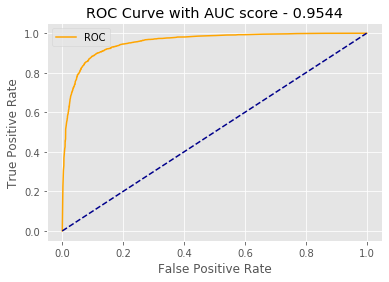

Bagging score
Accuracy score 0.89200
Cross val score 0.89917
Auc score 0.95439
Mean squared error - 0.28529
R2 score - 0.67441
-----------------------


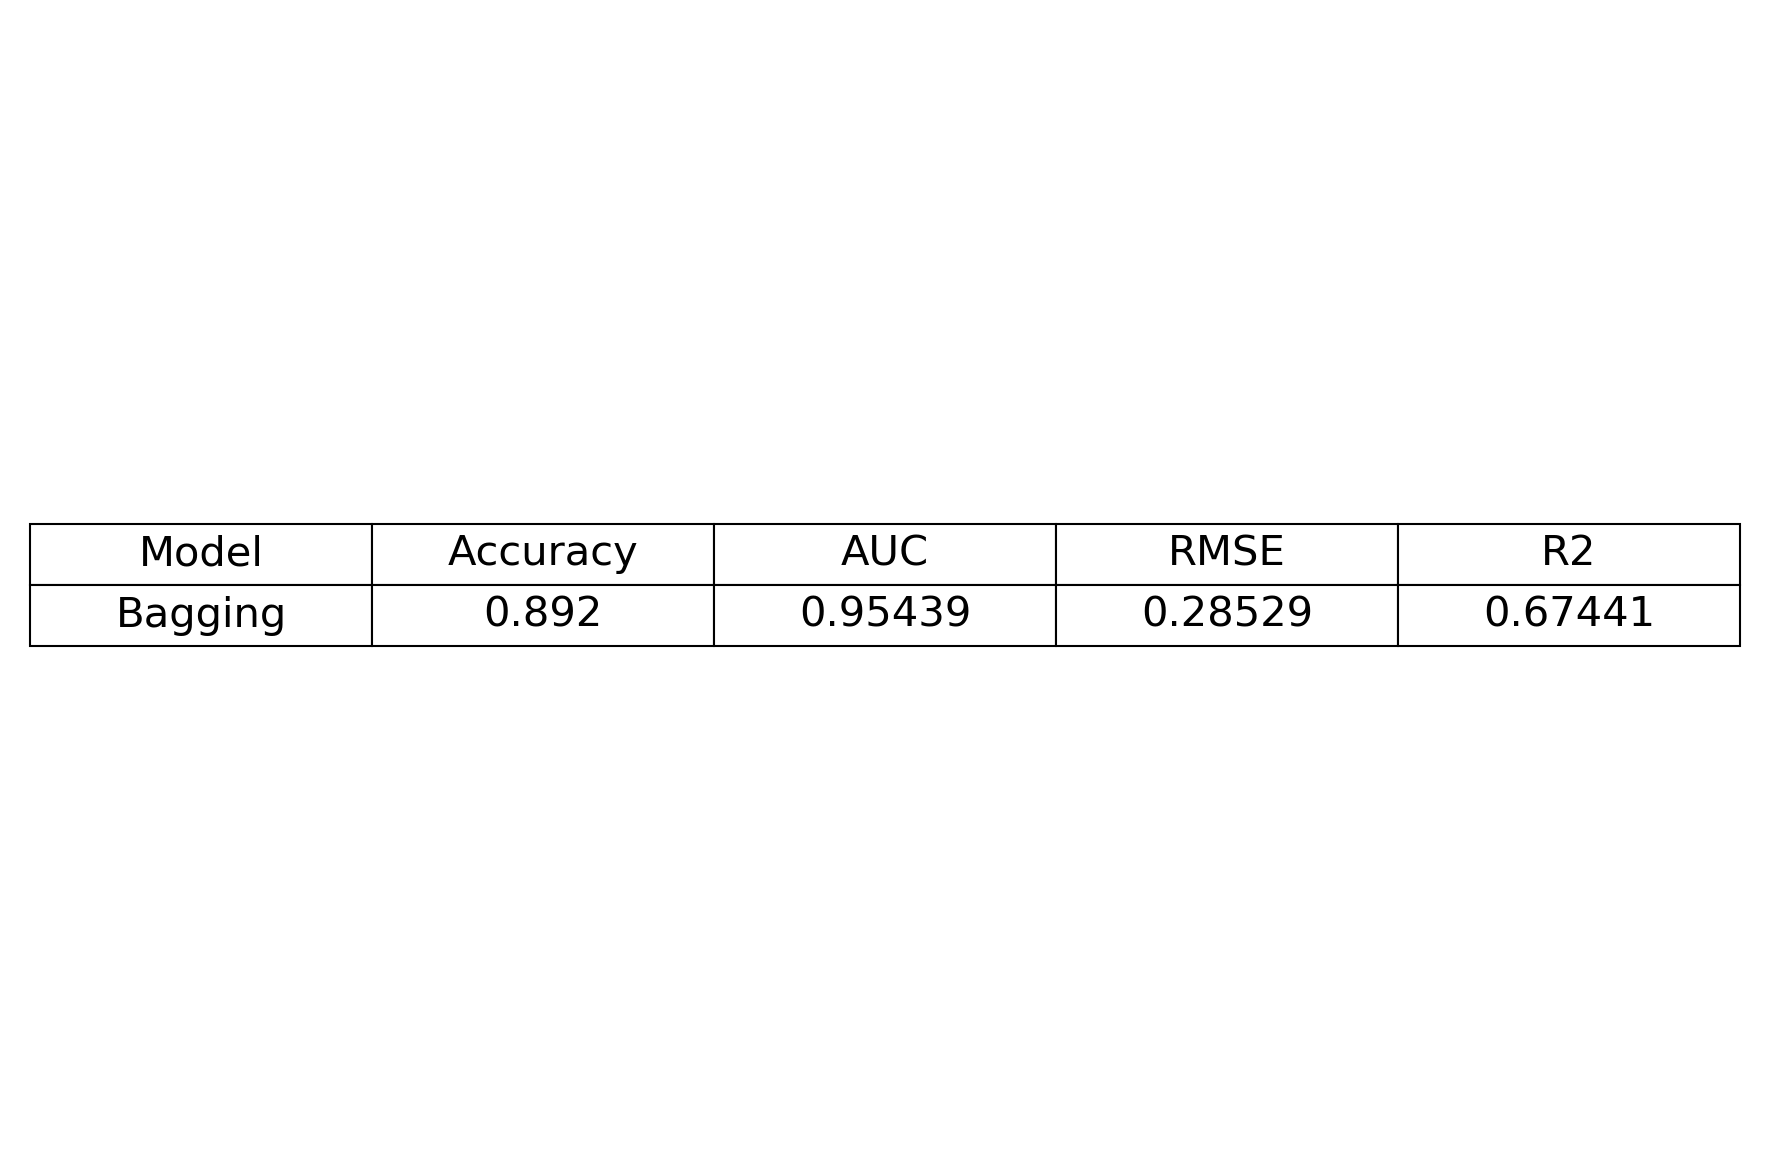

In [11]:
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

df = process_data_frame()
# Инициализируем массив для сбора результатов
x_table = []
#

target = 'Registration'

# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
x = df
x = x.drop(columns=[target])
y = df[target]
y = y.astype('int')

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для классификации по методу Бэггинга
#n_estimators - число деревьев
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#oob_score - Следует ли использовать готовые образцы для оценки ошибки обобщения
#n_jobs - по умолчанию стоит 1, но для распределения по ядрам устанавливаем -1
#bootstrap - отрисованы ли множества с заменой. Если False, выполняется выборка без замены.
model = BaggingClassifier(n_estimators=600,
                          n_jobs=-1,
                          random_state=4,
                          oob_score=True,
                          bootstrap=True
                          )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "bagging/roc/roc_curve", auc)

print('Bagging score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# Добавляем результаты модели
x_table.append(['Bagging', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
# Выводим
plot_score_table(x_table)

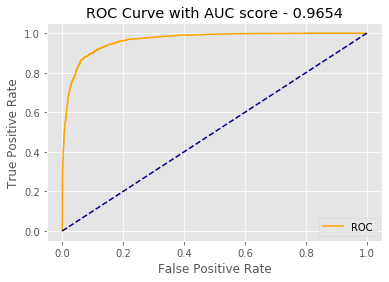

Gradient Boosting score
Accuracy score 0.90033
Cross val score 0.90992
Auc score 0.96535
Mean squared error - 0.26766
R2 score - 0.71341
-----------------------


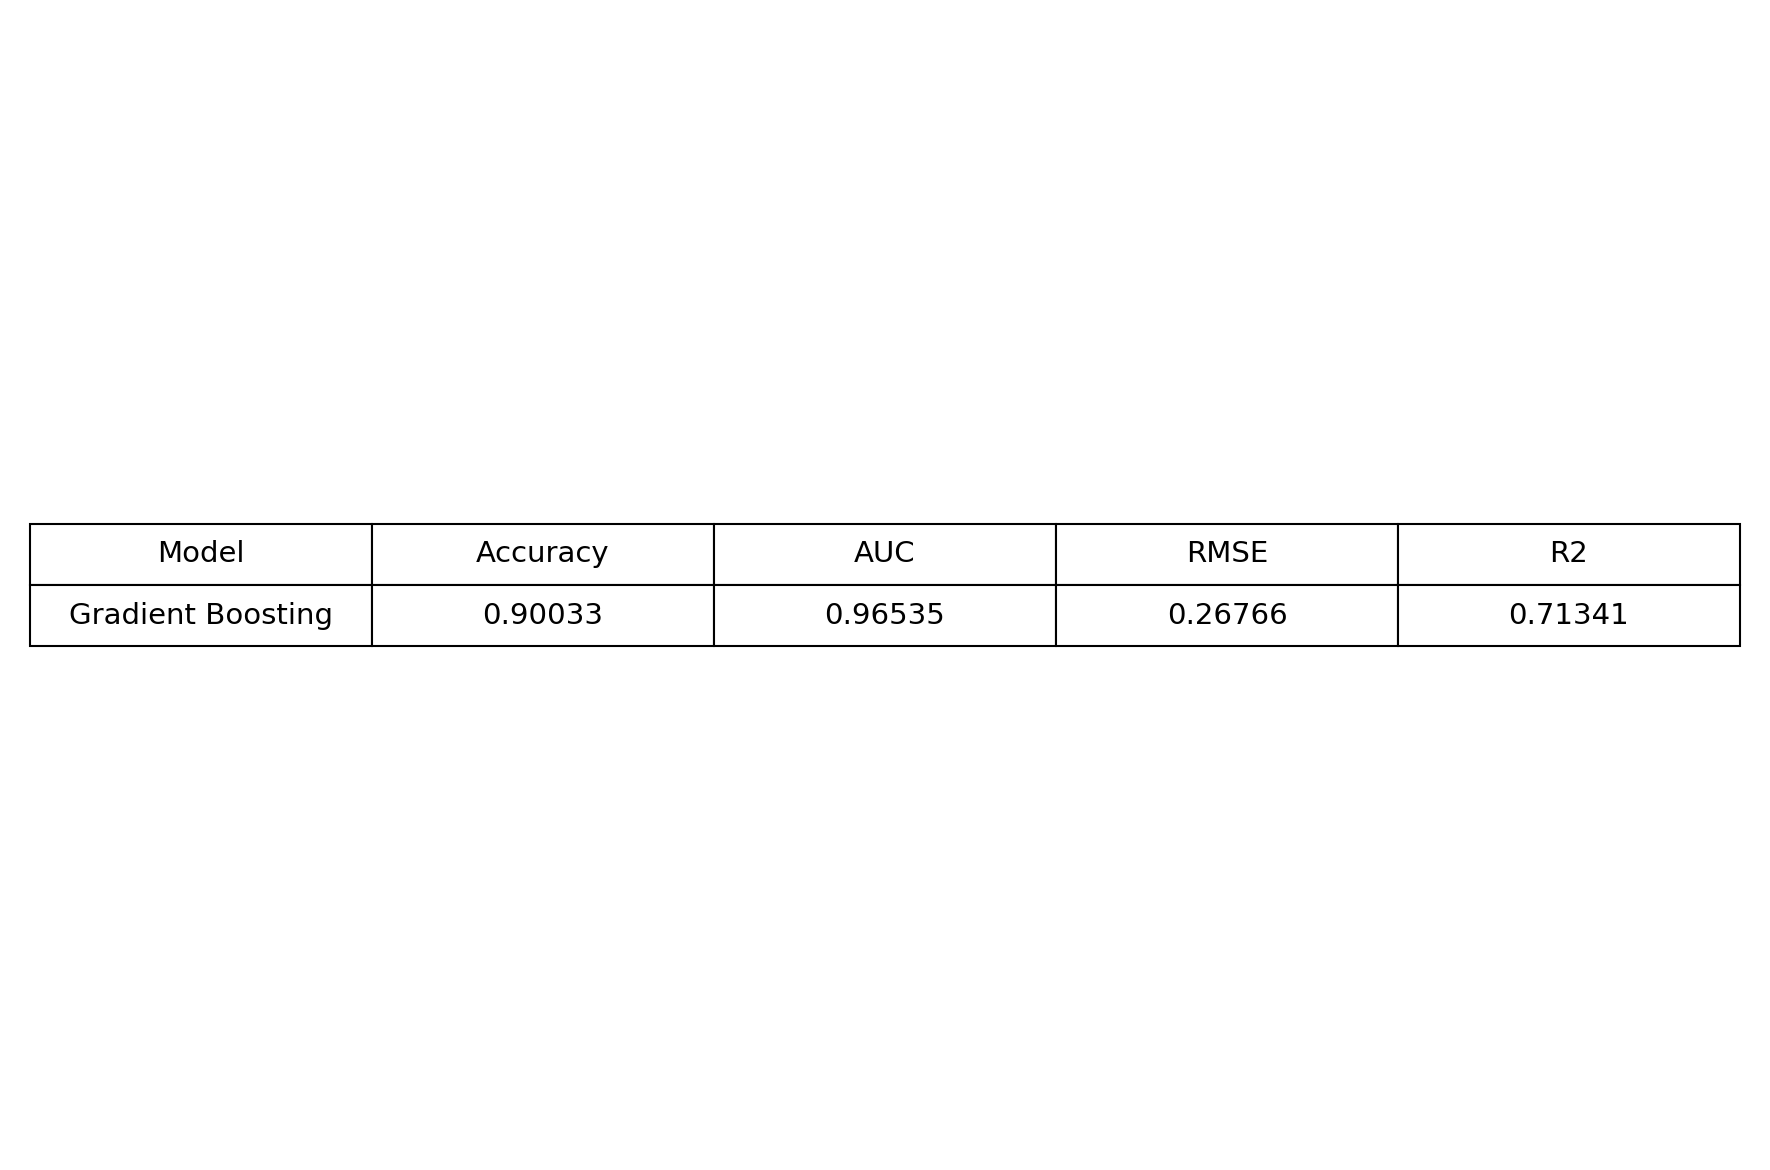

In [12]:
import numpy as np


from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

df = process_data_frame()
#
x_table = []
#

target = 'Registration'

# разбиваем данные на x и y
# где y - целевая переменная, которую мы хотим предсказать - выбираем регистрацию
# x - признаки, которые помогают предсказать y
# x не содержит y, так как в ином случае модель не будет обучаться 
x = df
x = x.drop(columns=[target])
y = df[target]
y = y.astype('int')

# функция импортирована
# разбиваем показатели, полученные ранее, на две подвыборки - обучающую и тестовую
# test_size - соотношение, в котором будет разбита обучающая выборка - 
# для тестового набора будет выделено 30% данных исходной обучающей выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#задаем свойства для классификации по методу градиентного бустинга
#n_estimators - число шагов
#learning_rate масштабирует длину шага процедуры градиентного спуска
#random_state генератор рандомных чисел, которые используются при построении модели и влияют на ее веса\коэффициенты, 
#по которым потом вычисляется предсказание.
#максимальная глубина 3
#max_features - задача классификации при построении этого ансамбля деревьев рекомендуется брать квадратный корень из всех признаков,
#чтобы деревья были более разнообразными
#warm_start - если True, повторно использовать решения предыдущего вызова для подгонки и добавить дополнительные оценки в ансамбль, 
#в противном случае просто подгонять целый новый ансамбль
#criterion (по дефолту friedman_mse) - функция для измерения качества разделения. 
# Значение по умолчанию «friedman_mse», как правило, является наилучшим, 
# поскольку в некоторых случаях оно может обеспечить лучшее приближение.
model = GradientBoostingClassifier(n_estimators=600,
                                   learning_rate=0.1,
                                   max_features='sqrt',
                                   warm_start=True,
                                   random_state=4,
                                   max_depth=3,
                                   criterion='friedman_mse'
                                   )

# строим модель
model.fit(x_train, y_train)

# оцениваем точность
current_score = model.score(x_test, y_test)

# оценка при кросс-валидации
val_score = max(cross_val_score(model, x_test, y_test, cv=5))

#генерируются предсказания, т.к у x еще нет значений, данный метод
#возвращает ID и значение, к какому классу, по его мнению, относится то или иное значение
probs = model.predict_proba(x_test)

# записываем только значения
probs = probs[:, 1]

# вычисление площади под ROC-кривой
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

# построение ROC-кривой
# fpr - false positive rate - ложноположительный показатель
# tpr - true positive rate - истинноположительный показатель
# thresholds - пороговые значения вероятности
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr, "gradient_boosting/roc", auc)

print('Gradient Boosting score')
print('Accuracy score %.5f' % round(current_score, 5))
print('Cross val score %.5f' % round(val_score, 5))
print('Auc score %.5f' % round(auc, 5))
print('Mean squared error - %.5f' % round(rmse, 5))
print('R2 score - %.5f' % round(r2, 5))
print('-----------------------')
# 
x_table.append(['Gradient Boosting', round(current_score, 5), round(auc, 5), round(rmse, 5), round(r2, 5)])
#
plot_score_table(x_table)
# ----------------------------

In [1]:
ВЫВОД
Проведя ислледование данных OnlineAds на поиск наилучшей модели для предсказания того, какие пользователи в будущем 
будут регистрироваться на площадке
Для того, чтобы понимать алгоритмы решений поиска оптимальной модели классификации,
мы, в среде разработки JupyterLab и языка программирования python, разобрали и 
научились использовать необходимые функции. 
Проведя анализ оценок, получившихся в результате построения моделей классификации, 
таких как логистическая регрессия, полиномиальная регрессия, дерево решений, 
рандомный лес, бэггинг, градиентный бустинг, можно сделать вывод, что наилучшими являются
методы градиентного бустинга, случайного леса и полиномиальной логистической регрессии.



SyntaxError: invalid syntax (<ipython-input-1-4e25d91f96cc>, line 2)